# NER ЛАботароная работа (пример)

Исследование новостей на русском языке на извлечение именованных сущностей

## Данные

In [ ]:
!pip install yargy -qq

     |████████████████████████████████| 41 kB 123 kB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 8.2 MB 38.2 MB/s 


In [ ]:
from google.colab import drive
import os
import pandas as pd
import spacy
from spacy.lang.ru.stop_words import STOP_WORDS
import re
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import string
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from yargy import Parser, rule, and_, not_, or_
from yargy.interpretation import fact
from yargy.relations import gnc_relation
from yargy.predicates import gram, is_capitalized, type, caseless, eq, custom, normalized, dictionary, in_caseless
from yargy.tokenizer import Tokenizer
from yargy.pipelines import caseless_pipeline
from wordcloud import WordCloud

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def list_files(dir):
  files_list = {}
  for root, dirs, files in os.walk(dir):
    for name in files:
      if 'txt' in name:
        name_annotation = name.split('.')[0] + '.ann'
        files_list[os.path.join(root, name)] = os.path.join(root, name_annotation)
  files_list = dict(list(files_list.items()))
  return files_list

def create_df(data_paths):
  files_dict_for_df = {'text': [], 'annotation': []}
  for file_path, file_annotation in data_paths.items():
    file_content = open(file_path, encoding="utf8").read()
    files_dict_for_df['text'].append(file_content)
    files_dict_for_df['annotation'].append(file_annotation)

  return pd.DataFrame(files_dict_for_df)

In [ ]:
data_paths = list_files("path_to_dataset")
df = create_df(data_paths)

В качестве данных используем коллекцию Named Entities 5, которую можно найти на http://labinform.ru/pub/named_entities/descr_ne.htm

В коллекции Named_Entities_5 разметка имен людей из коллекции Persons-1000 была дополнена следующими типами имен:

1.   организации (Org)
2.   источники информации - средства массовой информации, организации, имеющие функцию информирования (MEDIA)
3.   места (Loc)
4. государства (Geopolit), страны и столицы, выступающие в роли правительства
(например, «Москва анонсировала»)

## EDA

Так как в названиях организаций могут встречаться ковычки, а в сокращениях имен знаки препинани, уберем только остальные знаки, которые не помешают распознаванию. Также уберем из текста STOP_WORDS, взятые из библиотеки spicy

In [ ]:
def preprocessing(text):
  puncts = string.punctuation.replace('-', '').replace('"','').replace("'",'').replace('.', '')
  text_prep = text.replace('\n', ' ').replace('\r', '').strip()
  for punct in puncts:
    if punct in text_prep:
      text_prep = text_prep.replace(punct, '')
  text_prep = ' '.join([sentence.strip("!?.") for sentence in sent_tokenize(text_prep)])
  text_prep = re.sub(r'  +', ' ', text_prep)
  return text_prep


def remove_stopwords(sentence):
  all_stop_words = list(STOP_WORDS) + [word.capitalize() for word in STOP_WORDS]
  return " ".join([word for word in word_tokenize(sentence) if not word in all_stop_words])

In [ ]:
df['text'] = df['text'].apply(preprocessing)
df['text'] = list(map(remove_stopwords, df['text'].values))

In [ ]:
df.head()

,text,annotation
0,разгрома `` Динамо '' уволен главный тренер ``...,/content/gdrive/MyDrive/все подряд/учеба/магис...
1,Волошин возглавил совет директоров `` Норильск...,/content/gdrive/MyDrive/все подряд/учеба/магис...
2,Медведев уволил 12 генералов МВД Президент Рос...,/content/gdrive/MyDrive/все подряд/учеба/магис...
3,Д.Медведев назначил глав МВД Карачаево-Черкесс...,/content/gdrive/MyDrive/все подряд/учеба/магис...
4,А.Воробьеву разрешили сидеть двух стульях А.Во...,/content/gdrive/MyDrive/все подряд/учеба/магис...


Итоговый датасет имеет 2 столбца: текст и путь к аннотации с размечеными сущностями.

In [ ]:
def prep_line(text):
  prep_text = text.replace('\t', ' ').replace('\n', '').split(' ')
  return prep_text

def get_answers_df(annotation_path):
  with open(annotation_path, encoding='utf-8') as f:
    temp_list = [prep_line(line) for line in f]

  answer_dict_for_df = {'Id': [line[0] for line in temp_list],
                        'Tag': [line[1] for line in temp_list],
                        'Start': [line[2] for line in temp_list],
                        'End': [line[3] for line in temp_list],
                        'Answer': [' '.join(line[4:len(line)]) for line in temp_list]}

  return pd.DataFrame(answer_dict_for_df)

def count_tags(df):
  overall_dict = Counter([])
  for i in range(df.shape[0]):
    answers_df = get_answers_df(df['annotation'][i])
    answers_dict = Counter(answers_df['Tag'])
    overall_dict += answers_dict

  return overall_dict

In [ ]:
count_tags(df)

Counter({'ORG': 7033,
         'PER': 10623,
         'MEDIA': 1509,
         'GEOPOLIT': 4104,
         'LOC': 3140})

Больше всего в данном датасете размечено тэга Персоны, что не удивительно так как сам датасет был построен на Persons-1000. Также большой объем занимают организации и геополитика.

In [ ]:
def most_popular_tags_by_class(df, tag):
  overall_dict = Counter([])
  for i in range(df.shape[0]):
    answers_df = get_answers_df(df['annotation'][i])
    right_answers_tag = Counter(dict(answers_df[answers_df['Tag'] == tag]['Answer'].value_counts()))
    overall_dict += right_answers_tag
  count_tags_df = pd.DataFrame(overall_dict.most_common(15))
  count_tags_df.columns = ['word','count']
  return count_tags_df


def color_change(df):
  color_df = df.apply(lambda x: 'purple' if x>50 else 'blue')
  return list(color_df)

def plot_subplot_popular_tags(df):
  counter_class = count_tags(df)
  count_class = len(counter_class)
  fig, axs = plt.subplots(count_class, 1, figsize=(count_class*5, count_class*4))
  for num, tag in enumerate(counter_class.keys()):
    df_tags = most_popular_tags_by_class(df, tag)
    axs[num].bar(df_tags['word'], df_tags['count'], color=color_change(df_tags['count']))
    axs[num].set_ylabel('Count')
    axs[num].set_title(f'Most common words in class {tag}')
  plt.show()

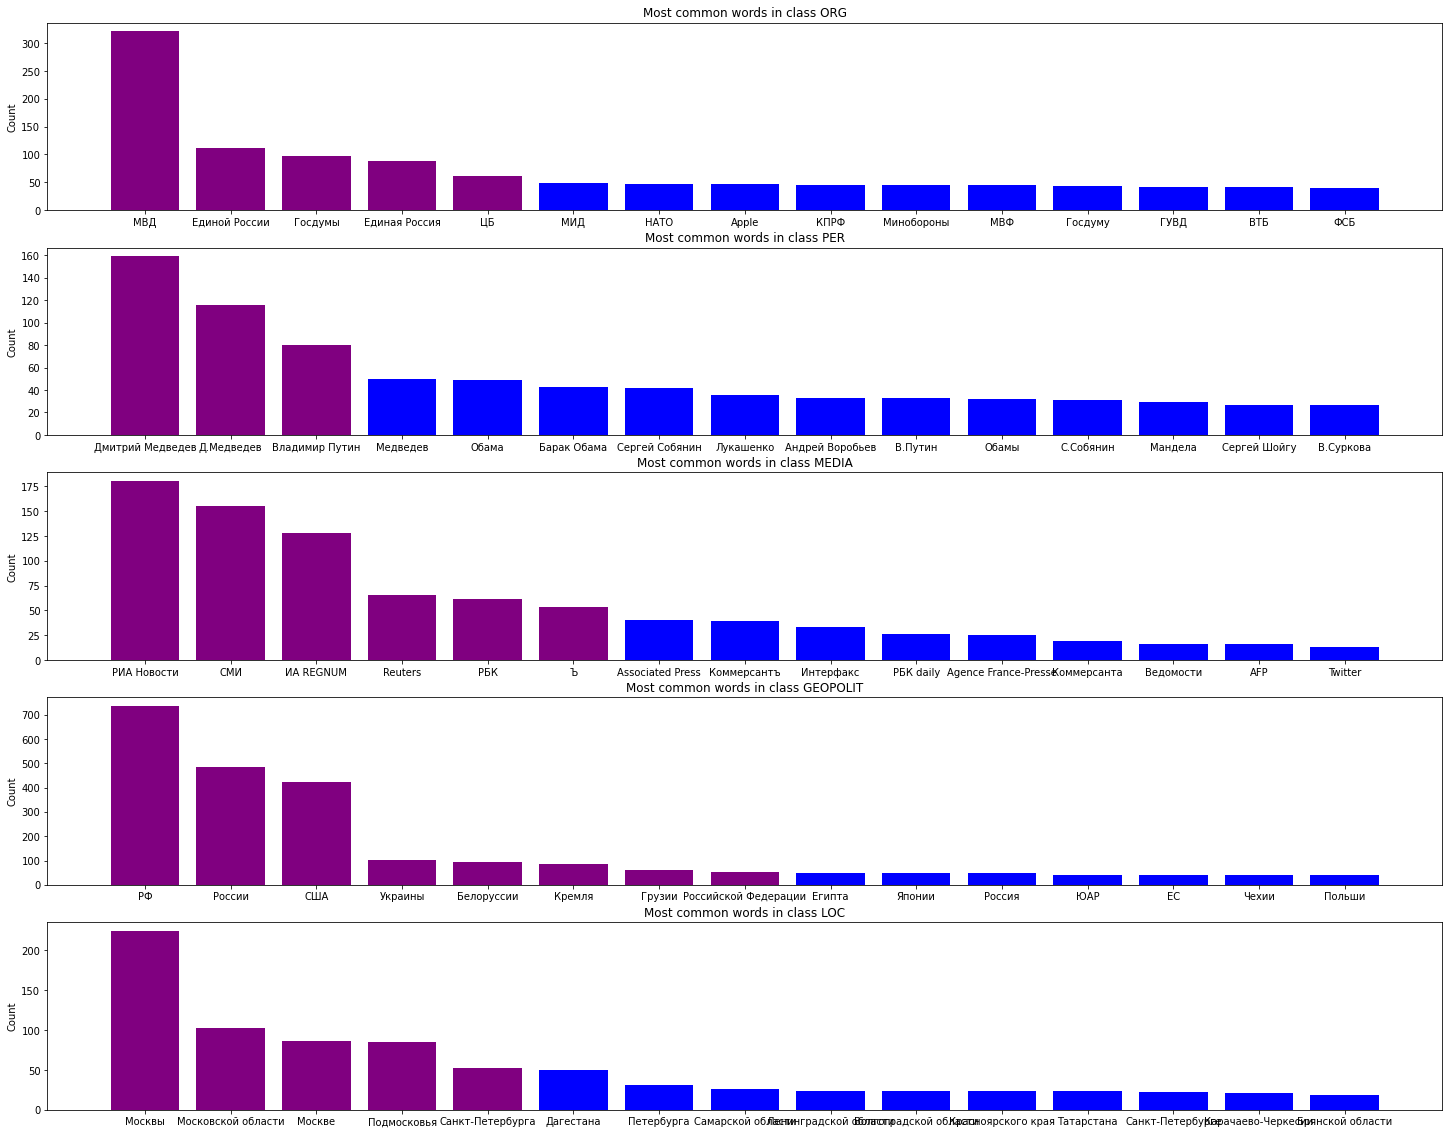

In [ ]:
plot_subplot_popular_tags(df)

В организациях чаще всего встречаются гос. учереждения, в людях президенты стран, данная особенность связана с тем, что в данных источниках больше всего новостей было связано с политикой. Забегая вперед, можно заметить, что будет сложно разделить классы LOC и GEOPOLIT, поэтому они будут считаться вместе.

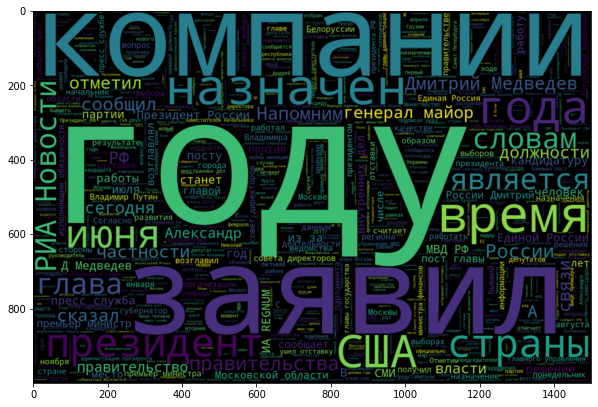

In [ ]:
wordcloud = WordCloud(max_words=800, width=1500, height=1000).generate(str(df.text.values))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')

## Извлечение сущностей

Для определения точностей будем строить матрицу корреляции для каждого теста.

In [ ]:
def calculate(matches, answers_df, tags):
  TP = 0
  FN = 0

  match_answers = [' '.join([_.value for _ in match_.tokens]).replace(' . ', '.').replace('. ', '.').replace(' - ', '-') for match_ in matches]
  right_answers_counter = Counter({})
  for tag in tags:
    right_answers_tag = Counter(dict(answers_df[answers_df['Tag'] == tag]['Answer'].value_counts()))
    right_answers_counter += right_answers_tag

  for key, value in right_answers_counter.items():
    for i in range(value):
      try:
        match_answers.remove(key)
        TP += 1
      except:
        FN += 1
  FP = len(match_answers)

  return TP, FP, FN

def predictions(df, parser, tags):
  true_positive = 0
  false_positive = 0
  false_negative = 0

  for index, row in df.iterrows():
    matches = parser.findall(row['text'])
    answers_df = get_answers_df(row['annotation'])

    TP, FP, FN = calculate(matches, answers_df, tags)

    true_positive += TP
    false_positive += FP
    false_negative += FN

  return true_positive, false_positive, false_negative

def draw_heatmap(TP, FP, FN):
  heatmatrix = pd.DataFrame([[TP, FP], [FN, 0]], ['predict - yes', 'predict - no'], ['actual - yes', 'actual - no'])
  plt.figure(figsize = (7, 5))
  sns.heatmap(heatmatrix, annot=True, annot_kws={"size": 16}, fmt='g')

### Правила

В качестве библиотеки для создания правил по ruled-based подходу будем использовать **yaggi**, так как он самый вариативный в использовании.

In [ ]:
DASH = eq('-')
LONG_DASH = eq('—')
DOT = eq('.')
QUOTES = eq('"')
SINGLE_QUOTES = eq("'")

#### Персоны

В данных правилах описаны такие формы имени:

*   Имя Фамилия Отчество (возможно)
*   Фамилия Имя Отчество (возможно)
*   Имя Отчество Фамилия (возможно)
*   И.О Фамилия
*   И. Фамилия
*   Имя
*   Фамилия
*   Отчество

А также фамилии расмотрены в нескольких видах:

1.   Обычная фамилия
2.   Фамилия через дефис
3.   Фамилия с префиксом (иностранные)


In [ ]:
def is_surname(name):
  russian_endings = ['ов', 'ова','ев', 'ева', 'ин', 'ина', 'ын', 'ына', 'их', 'ых', 'ский', 'ская', 'цкий', 'цкая']
  for ending in russian_endings:
    if name.endwith(ending):
      return name

In [ ]:
Person = fact(
    'Person',
    ['first', 'last', 'patronymic']
)

In [ ]:
gnc = gnc_relation()
SURNAME_LIKE_NAME = gram('Name').interpretation(Person.last.custom(is_surname))
FIRST = and_(gram('Name'), is_capitalized()).interpretation(Person.first).match(gnc)
SURNAME = and_(gram('Surn'), is_capitalized())
ABBR = and_(gram('Abbr'), gram('Name'), is_capitalized())
PATRONYMIC = and_(gram('Patr'), is_capitalized()).interpretation(Person.patronymic).match(gnc)

In [ ]:
PERSON_DASH_SURNAME = rule(SURNAME, or_(DASH, LONG_DASH), SURNAME)
PERSON_SURNAME = rule(or_(rule(SURNAME), PERSON_DASH_SURNAME)).interpretation(Person.last).match(gnc)
ABBR_DOT = rule(ABBR, DOT.optional())

PERSON_ABBR_FULL = rule(
    ABBR_DOT.interpretation(Person.first),
    ABBR_DOT.optional().interpretation(Person.patronymic),
    PERSON_SURNAME
)

FIRST_LIKE_NAME_NOUN = and_(or_(gram('Name'), gram('NOUN')), is_capitalized()).interpretation(Person.first)
SURNAME_PREFIX = caseless_pipeline(['фон', 'де', 'дель', 'де ла'])
SURNAME_LIKE_NAME_NOUN = and_(or_(gram('Surn'), gram('NOUN')), is_capitalized())
PERSON_SURNAME_PREFIX = rule(
    FIRST_LIKE_NAME_NOUN,
    rule(SURNAME_PREFIX, SURNAME_LIKE_NAME_NOUN).interpretation(Person.last)
)

In [ ]:
PERSON_INFO = or_(
    rule(FIRST, PERSON_SURNAME, PATRONYMIC.optional()),
    rule(PERSON_SURNAME, FIRST, PATRONYMIC.optional()),
    rule(FIRST, PATRONYMIC, PERSON_SURNAME.optional()),
    rule(SURNAME_LIKE_NAME, FIRST, PATRONYMIC.optional()),
    rule(FIRST, SURNAME_LIKE_NAME, PATRONYMIC.optional()),
    PERSON_ABBR_FULL,
    PERSON_SURNAME_PREFIX,
    rule(FIRST),
    rule(PERSON_SURNAME),
    rule(PATRONYMIC),
).interpretation(Person)

#### Места

С местами немного тяжелее, так как они могут описываться обычными существительными. Основные правила основаны на **gram('Geox')** с добавлением прилагательных, наречий, дефисов, слов обозначающих регион.

In [ ]:
Location = fact(
    'Location',
    ['loc']
)

In [ ]:
ADJF = gram('ADJF')
GEOX = gram('Geox')
ADVB = gram('ADVB')
ADJF_CAP = and_(ADJF, is_capitalized())
GEOX_CAP = and_(GEOX, is_capitalized())
ADVB_CAP = and_(ADVB, is_capitalized())
region_dict = dictionary({'федерация', 'республика', 'край', 'область', 'округ', 'АО', 'район'})

In [ ]:
LOC_BASE = rule(ADJF.optional(), GEOX).interpretation(Location.loc)

LOC_DASH = rule(
    ADJF.optional(),
    GEOX,
    or_(DASH, LONG_DASH),
    GEOX
).interpretation(Location.loc)

LOC_REGION_END = rule(
    or_(ADVB, GEOX).optional(),
    or_(DASH, LONG_DASH).optional(),
    ADJF_CAP,
    ADJF.optional().repeatable(),
    region_dict
).interpretation(Location.loc)

LOC_REGION_START = rule(
    region_dict,
    ADJF.optional(),
    GEOX
).interpretation(Location.loc)

In [ ]:
LOC_INFO = or_(
    LOC_BASE,
    LOC_DASH,
    LOC_REGION_END,
    LOC_REGION_START
).interpretation(Location)

### Подсчет


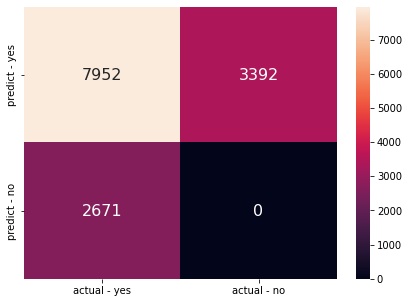

In [ ]:
parser_person = Parser(PERSON_INFO)
TP, FP, FN = predictions(df, parser_person, ['PER'])
draw_heatmap(TP, FP, FN)

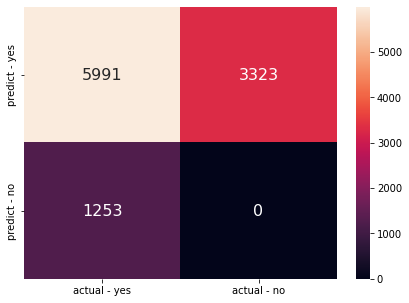

In [ ]:
location_parser = Parser(LOC_INFO)
TP, FP, FN = predictions(df, location_parser, ['LOC', 'GEOPOLIT'])
draw_heatmap(TP, FP, FN)

## Выводы

Для ruled-based подхода очень сложно сделать большую точность, связано это с тем, что имеется куча исключений, обычных существительных слов, которые в русском языке обозначают места или организации. Множество слов могут без привязки к фамилии обозначать несколько вещей одновременно.

Отдеальной проблемой являются иностранные слова, написанные на русском языке. Это видно как в фамилиях, так и в заимствованных словах для организаций.

Но при этом, процент TP довольно внушительный. Это связано с тем, что большинство слов встречается много раз, а ошибается модель на словах редковстречающихся.

Преимуществом ruled-based подхода над нейросетевым является его вариативность и простота. Любое правило можно изменить и дополнить по результатам теста. Но к сожалению, не любое правило в целом можно написать.

